# Sprint16課題 論文読解入門

## 1.この課題の目的

- 論文に触れ続ける一歩目を踏み出す
- 論文から有益な情報を引き出せるようにする
- これまで扱ってきた領域の論文から新たな知識を得る

## 2.論文読解

以下の論文を読み問題に答えること。（CNNを使った物体検出（Object Detection）の代表的な研究である）

[8]Ren, S., He, K., Girshick, R., Sun, J.: Faster r-cnn: Towards real-time object detection with region proposal networks. In: Advances in neural information processing systems. (2015) 91–99

https://arxiv.org/pdf/1506.01497.pdf

## 問題
それぞれについてJupyter Notebookにマークダウン形式で記述すること。

(1) 物体検出の分野にはどういった手法が存在したか。

(2) Fasterとあるが、どういった仕組みで高速化したのか。

(3) One-Stageの手法とTwo-Stageの手法はどう違うのか。

(4) RPNとは何か。

(5) RoIプーリングとは何か。

(6) Anchorのサイズはどうするのが適切か。

(7) 何というデータセットを使い、先行研究に比べどういった指標値が得られているか。

(8) （アドバンス）Faster R-CNNよりも新しい物体検出の論文では、Faster R-CNNがどう引用されているか。

## 条件

- 答える際は論文のどの部分からそれが分かるかを書く。
- 必要に応じて先行研究（引用されている論文）も探しにいく。最低2つは他の論文を利用して回答すること。
- 論文の紹介記事を見ても良い。ただし、答えは論文内に根拠を探すこと。

## 読解内容

#### 0. Faster R-CNNモデルの構造

- 入力：画像データ（サンプル数：１、チャンネル：１、高さ：m、横幅：n）


- 処理：
    - 畳み込み層のフィルターサイズ：（sample：１, channe：１, Height：３, Width：３）
    - 出力の形状： (sample : N, Channel :  256, Height : 3, Width : 3) 
    - Convolutional Feature Map：W × H （typically = ~2,400 => 大元の画像は50 * 50 pxを想定）
    - アンカーボックス：スケール（m個）とアスペクト比（n個）が異なる複数の種類を用意。=> Faseter-RNNでは、m, nともに3を想定（計９種類）
    - Region Proposal Network（RPN）：（サンプル数：256, チャンネル数：9, 特徴量：6）=> 学習過程で、物体検知（物体 or notの二値分類）、および物体の位置情報（座標）の最適化を同時に行う。    


- MultiBox法の場合、k-meansで生成した800個のアンカーが、フィルタ位置（４次元）＋物体のクラス（１次元）の情報を有する。

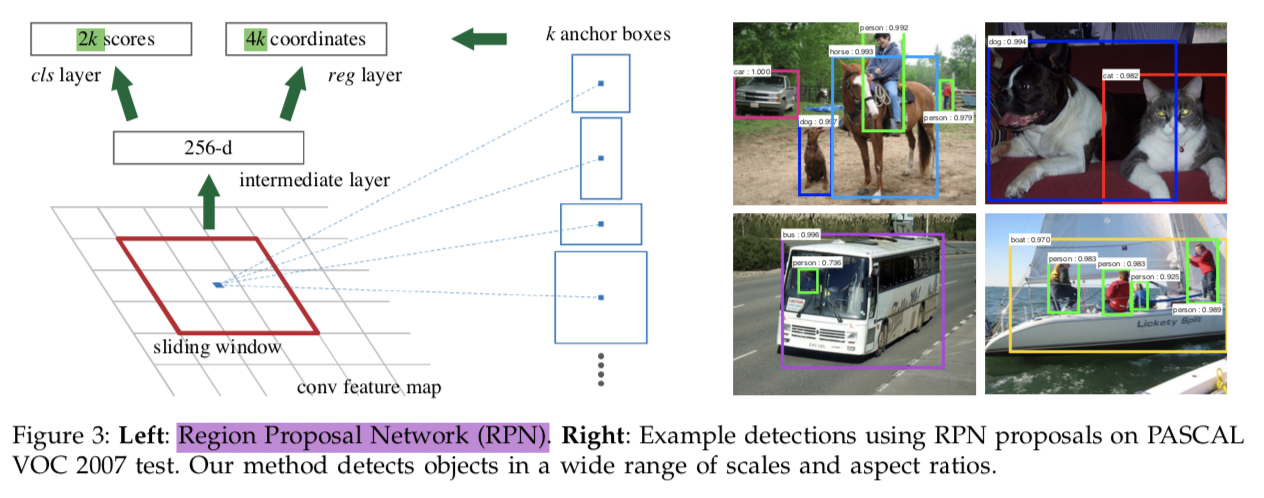

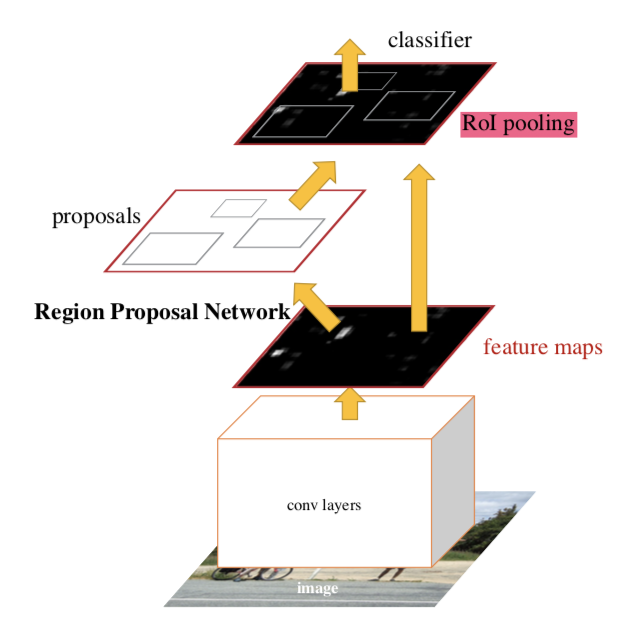

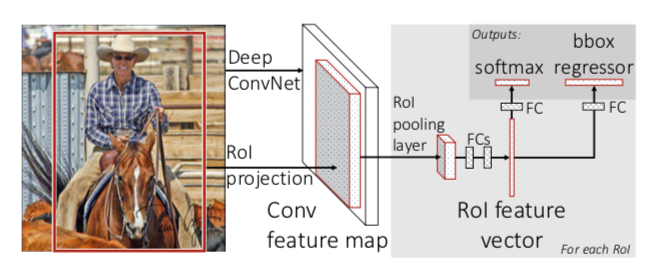

#### 1. 物体検出の分野にはどういった手法が存在したか。

**- Selective Search object detectors**
- 最も一般的な手法であり、ピクセルレベルで類似する領域をグルーピングすることで、物体らしき領域を発見する。<br> => *One of the most popular methods, greedily merges superpixels based on engineered low-level features.*

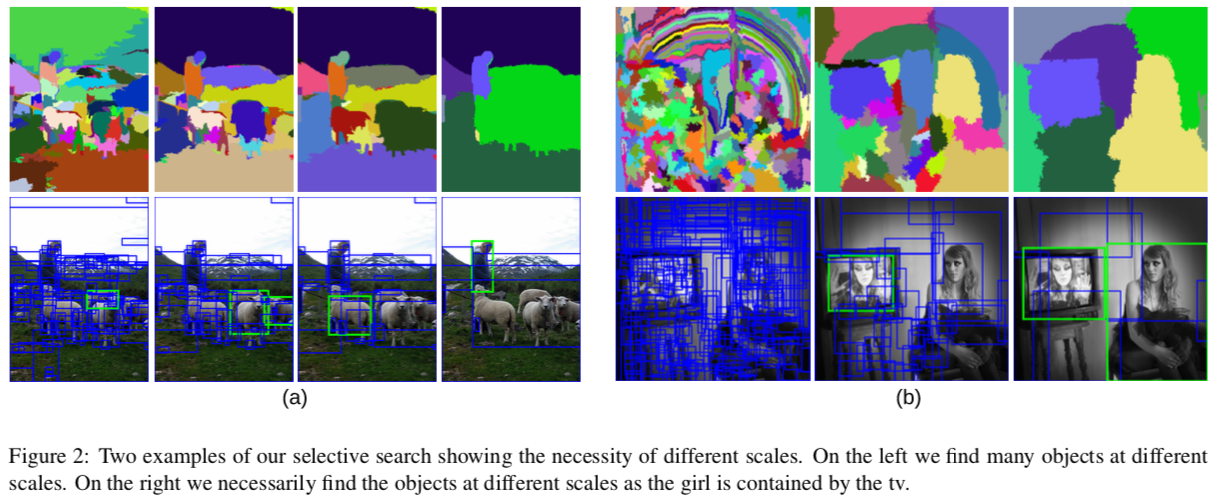

- **EdgeBoxes**
    - 物体領域の適正値（box objectness score）を＜ボックス内に存在するエッジの数 - ボックスの境界に重なる輪郭の数＞として算出する。物体領域が小さすぎる場合、ボックスの境界と物体の重なりが大きくなり、scoreが低下する仕組み。
    <br> =>*We propose a simple box objectness score that measures the number of edges that exist in the box minus those that are members of contours that overlap the box’s boundary.*
    
    - 物体領域の質（範囲の適切さ）と領域出力までの時間（速度）の間に存在するトレードオフが緩和され、画像あたり2秒で物体領域（region）が出力される。 <br> =>*EdgeBoxes currently provides the best tradeoff between proposal quality and speed, at 0.2 seconds per image.*

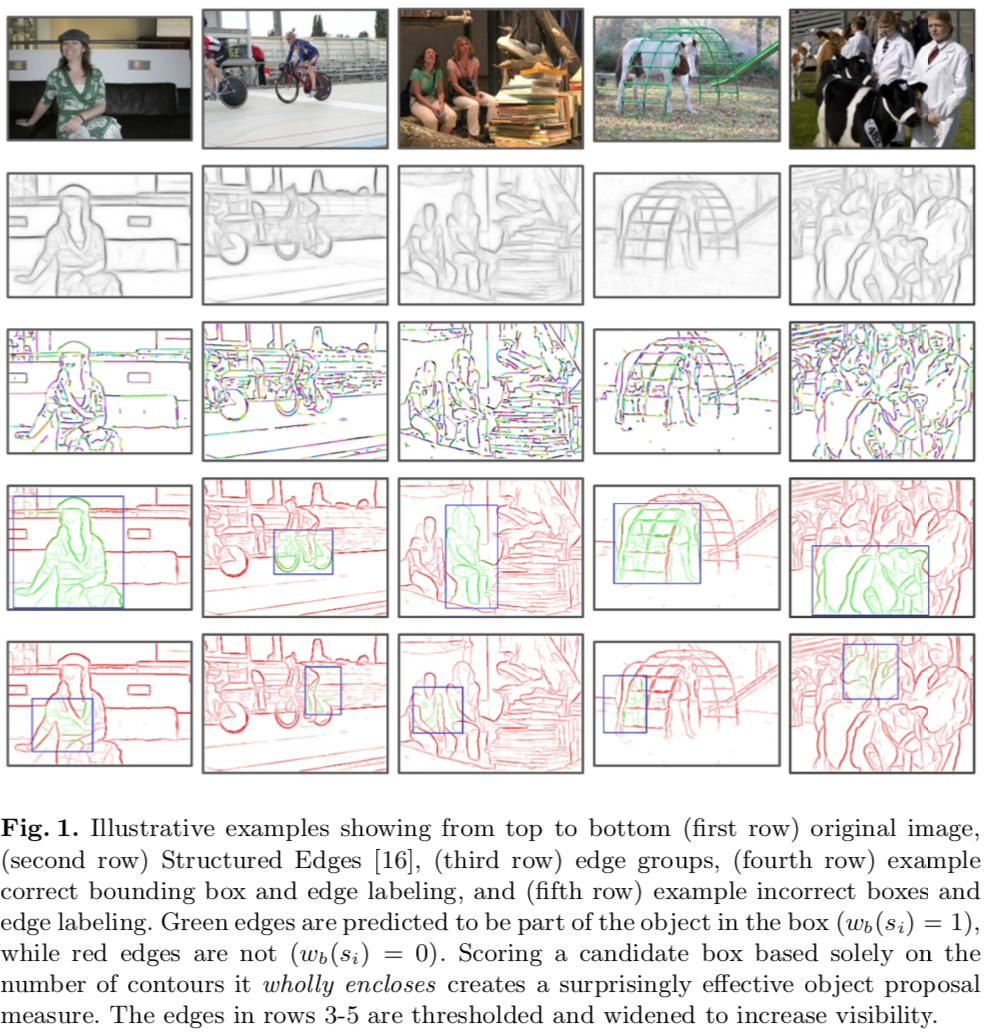

- **R-CNN /  Fast R-CNN**
    - R-CNNは、CNNをend-to-endで学習させ、物体のクラス、背景を分類するもの。<br> => *The R-CNN method trains CNNs end-to-end to classify the proposal regions into object categories or background.*
    - R-CNNは物体領域を予測するわけではない。<br> => *R-CNN mainly plays as a classifier, and it does not predict object bounds (except for refining by bounding box regression).*
    - 適合率はregion proposalの精度に依存する。<br> => *Its accuracy depends on the performance of the region proposal module.*

#### 2. Fasterとあるが、どういった仕組みで高速化したのか。

従来のR-CNNに「RPN（Region Proposal Networks）」を組み込むことで高速化した。

- 先行手法の課題は何か？：region proposal（物体領域）の検出に時間を要した。
    
    - Selective Search：画像１枚あたり2秒を要する <br> => *Yet when compared to efficient detection networks, Selective Search is an order of magnitude slower, at 2 seconds per image in a CPU implementation.*
    
    - MultiBox法：出力層のパラメーター数（＝6.1×$10^6$個）が多い。（Faster R-CNNでは出力層のパラメーター数が2.8×$10^4$個であり２桁小さい）。<br> =>*As a result, our output layer has 2.8 × $10^4$ parameters (512 × (4 + 2) × 9 for VGG-16), two orders of magnitude fewer than MultiBox’s output layer that has 6.1 × $10^6$ parameters (1536 × (4 + 1) × 800 for GoogleNet in MultiBox).*


- Faster R-CNNにおける高速化の肝は何か？
    - 畳み込み時に生成したfeature mapをregion proposalの生成にも用いる（＝層を共有する）。これにより、計算時間を2sから1msに短縮した。<br> => *By sharing convolutions at test-time, the marginal cost for computing proposals is small (e.g., 10ms per image). Our observation is that the convolutional feature maps used by region-based detectors, like Fast R- CNN, can also be used for generating region proposals.*
    
    - 具体的には、グリッド上の各位置で領域境界（region bounds）および物体の確からしさ（objectness score）を同時に回帰する。 <br> => *On top of these convolutional features, we construct an RPN by adding a few additional convolutional layers that simultaneously regress region bounds and objectness scores at each location on a regular grid.*

    - また、１つのフィルタサイズでマルチスケールの物体領域に対応できるようにアンカーをデザインしたことで、追加的な計算コストを伴うことなく主要なの特徴を共有することができるようになった。 <br> => *We show by experiments the effects of this scheme for addressing multiple scales and sizes (Table 8). The design of multi-scale anchors is a key component for sharing features without extra cost for addressing scales.*

#### 3. One-Stageの手法とTwo-Stageの手法はどう違うのか。

One-Stageの手法は「物体を特定するproposalのみ出力する」のに対して、Two-stageの手法は「①物体のクラスを特定しないproposal（＝物体 or 背景の２択）を実施した上で、②物体のクラス分類結果」を出力する。<br> => *OverFeat is a one-stage, class-specific detection pipeline, and ours is a two-stage cascade consisting of class-agnostic proposals and class-specific detections.*

＜以下、Faster R-CNNにおける検知プロセス＞

1. One-Stage Detection：
    - 第１段階として、１つのアスペクト比を持つ複数サイズのフィルタ（＝scale pyramid）によりフィルタリングを行い、①位置情報の特定、及び②指定範囲の特徴量を用いた物体検知（物体 or 背景の二値分類）を行う。<br> => *In OverFeat, the region-wise features come from a sliding window of one aspect ratio over a scale pyramid. These features are used to simultaneously determine the location and category of objects.*


2. Two-Stage Detection：
    - 第2段階では、（第１段階で決定した）proposal boxから各領域の特徴量を逐次的にプーリングすることで、領域全体の特徴を保持しながら少ないデータ量で学習を行う。<br> => *In the second stage of our cascade, the region-wise features are adaptively pooled from proposal boxes that more faithfully cover the features of the regions.*

#### 4. RPNとは何か。

以下、3.1 Region Proposal Networksを参照。

- RPN概要
  <br> => 画像データを入力すると、①物体認識の範囲（rectangular object proposal）、及び②物体の存在確率（＝objectness score）を出力するもの。


- RPNでは「end-to-end」で確率的勾配降下法による学習を行う。
<br> => *The RPN can be trained end-to-end by back-propagation and stochastic gradient descent (SGD).*


- 以下の基準で学習に用いるアンカー（objectと判断する箇所）を選定する：
    - IoU（アンカーの重なり）が0.7以上の場合は、１つのground-truthbox（元の画像データの畳み込まれた箇所）に対応する複数のアンカーに対してpositive-labelを割り当てる。
    - IoUが0.3以下の場合はnegative-labelを割り当て、labelがpositiveでもnegativeでもない場合（0.3 < IoU < 0.7）は学習に用いない。


- positive-labelとnegativi-labelの比率が1:1となるようにアンカーからランダムに256サンプルを抽出し、損失を計算する。
    <br> => *We randomly sample 256 anchors in an image to compute the loss function of a mini-batch, where the sampled positive and negative anchors have a ratio of up to 1:1.*


- 新たに生成したレイヤーのパラメーターは標準偏差0.01のガウス分布で重みを初期化し、その他のレイヤー（共有する畳み込み層）はImageNet Classification用に事前学習されたモデルで初期化する。 <br> => *We randomly initialize all new layers by drawing weights from a zero-mean Gaussian distribution with standard deviation 0.01. All other layers (i.e., the shared convolutional layers) are initialized by pre-training a model for ImageNet classification, as is standard practice.*


- 損失関数はR-CNNと同様のmulti-task loss functionを想定（以下、参考文献[2]より抜粋）している。（＝マルチタスク損失関数の最小化は、物体の確からしさ、及び位置情報の正確性を同時に最大化しようとする試みと解釈できる）<br> => *We use a multi-task loss L on each labeled RoI to jointly train for classification and bounding-box regression: L(p, u, tu, v) = Lcls(p, u) + λ[u ≥ 1]Lloc(tu, v), (1) in which Lcls (p, u) = − log pu is log loss for true class u.*

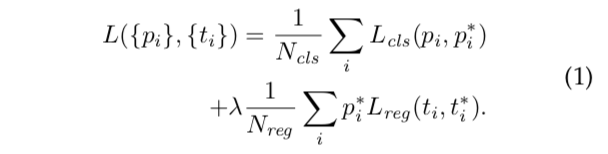


- 損失関数のハイパーパラメータの$λ$は、存在確率の誤差に対する位置情報の誤差の重みであり、Faster R-CNNの場合は$λ=10$とすることで存在確率と位置情報を同等に扱っている。<br> => *By default we set λ = 10, and thus both cls and reg terms are roughly equally weighted.*


- positive-labelが割り当てられたアンカーのみ、損失の計算に用いる。<br> => *The term $p_i$ Lreg means the regression loss is activated only for positive anchors ($p^{*}_i$ = 1) and is disabled otherwise ($p^{*}_i$ = 0). The outputs of the cls and reg layers consist of {pi} and {ti} respectively.*


- Non-Maximum Suppression（IoUの閾値を用いた重複領域の抑制アルゴリズム）を適用して物体領域（矩形）のみを残す。 <br> => *To reduce redundancy, we adopt non-maximum suppression (NMS) on the proposal regions based on their cls scores.*


#### 5. RoIプーリングとは何か。

- RoIとは"Region of Interst"の略語であり、 feature map上で物体の確からしさ（Objectiveness Score）が高い箇所を意味する（参考文献[2]参照）。

- RoIプーリングとは、RoIのみを抽出してプーリング層(通常はmax pooling）を形成すること。RoIプーリングにより、（２段階目で行う）クラス分類に必要なデータ量を抑える（＝RoI以外の箇所は用いない）。<br> => *The RoI pooling layer uses max pooling to convert the features inside any valid region of interest into a small feature map with a fixed spatial extent of H × W (e.g., 7 × 7), where H and W are layer hyper-parameters that are independent of any particular RoI.* （参考文献[2]より）

#### 6. Anchorのサイズはどうするのが適切か。

スケールとアスペクト比を調整し、複数パターンを用いる。（関連箇所は以下の通り）

- ｋ個の提案領域（region proposal）は、アンカーと呼ぶｋ個の参照ボックスに対してパラメータ化されている。
<br>=>*The k proposals are parameterized relative to k reference boxes, which we call anchors.*

- アンカーは、スライディングウィンドウの中心にあり、スケールと縦横比に関連付けられている。
<br> =>*An anchor is centered at the sliding window in question and is associated with a scale and aspect ratio.*

- デフォルトでは、3つのスケールと3つの縦横比を使用し、各スライド位置で$k$=9のアンカーを生成する。
<br>=> *By default we use 3 scales and 3 aspect ratios, yielding k = 9 anchors at each sliding position.*

- サイズW×H（通常は〜2400）のconvolutional feature mapの場合、合計でW×H×K個のアンカーがある。
<br> => *For a convolutional feature map of a size W × H (typically ~ 2400),  there are WHK anchors in total.*

- Faster R-CNNのAnchor-based methodは、 Anchor pyramid（単一サイズのアンカーを、スケールやアスペクト比を調整して拡張する）の上に構築されており、最もコスト効率的である（計算コストが小さい）。
<br> => *As a comparison, our anchor-based method is built on a pyramid of anchors, which is more cost-efficient.*

- 複数のスケールとアスペクト比のアンカーボックスを参照してバウンディングボックスを分類して回帰する。
<br> => *Our method classifies and regresses bounding boxes with reference to anchor boxes of multiple scales and aspect ratios.*

- 単一スケールの画像とfeature mapにのみ依存し、単一サイズのフィルタ（feature map上のsliding window）を使用する。
<br> => *It only relies on images and feature maps of a single scale and uses filters (sliding windows on the feature map) of a single size.*

#### 7. 何というデータセットを使い、先行研究に比べどういった指標値が得られているか。

1. データセット：PASCAL VOC 2007を用いた。
    - PASCAL VOC 2007 detection benchmarkを用いて、今回の手法（Faster R-CNN）を評価する。
<br> => *We comprehensively evaluate our method on the PASCAL VOC 2007 detection benchmark.* 

    - このデータセットは、20個のオブジェクトカテゴリにわたる約5000枚の学習用データ、及び約5000枚のテストデータで構成されている。
<br>  => *This dataset consists of about 5k trainval images and 5k test images over 20 object categories.*


2. 評価指標：mAP（mean Average Precision）を用いた。
    - Average Precisionは、PrecisionをRecallについて平均を計算したもので、Precisionを縦軸、Recallを横軸にしたPrecision-Recall curveの曲線以下の部分の面積(AUC, Area Under the Curve)として計算される。

3. 評価結果：
    - Fast R-CNNを使用したRPNによる評価は、最大300のregion proposalを使用し、59.9％のmAPとなった。（先行研究より改善）
<br> => RPN with Fast R-CNN achieves competitive results, with an mAP of 59.9% while using up to 300 proposals.
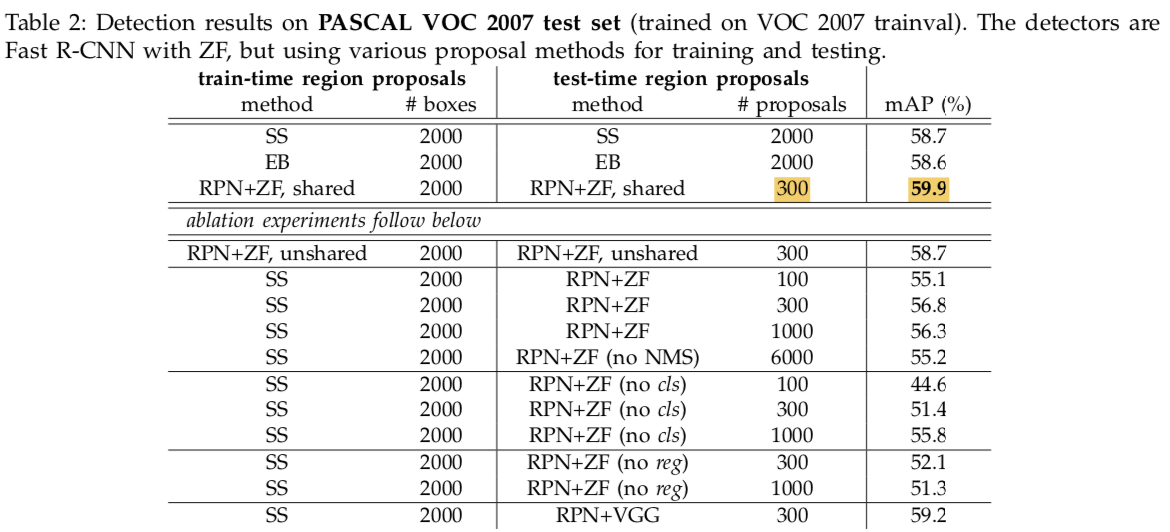

### Take away

Faster R-CNNに関する論文読解を通じて、物体検知の基礎を理解した。

- Faster R-CNNの最終的な出力は、①物体の位置情報（objectness score、anchorに基づく）、及び②検知した物体のクラスである。

- 損失関数を、物体の位置情報に関する損失、及び物体のクラスに関する損失の加重平均で定義することにより、RPNの学習過程で物体検知とクラス分類が同時に行われる仕組みとなっている。既出の損失関数を徒に用いるのではなく、解くべき問題に対して、自ら適切な損失関数を定義できるようになりたい。（この辺の工夫がアルゴリズム改良の見せ所か？）

- 物体の位置情報に関しては、アンカーボックスを用いて特定する。（アンカーボックスを予め複数パターン用意するのではなく、スケールやアスペクト比のパターンを作っておくことで、多様なアンカーボックスを柔軟に作り出すことができる点は学びとなった）。

- また、Selective SearchやEdgeBox等、先行研究にも目を通すことで、アルゴリズムの進化の歴史を知ることが出来た。論文は信頼性が高い情報を効率的に獲得できるソースであると実感したので、「先行研究と何がどのように異なるのか」「技術の肝は何か」という観点で、今後も継続的に論文を読み進めていきたい。